In [154]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules
from numba import vectorize

def bissection_onestep(f,a,b):
    if not np.all(f(a)*f(b) <= 0):
        raise ValueError("No sign change")
    else:
        mid_point = (a + b)/2
        mid_value = f(mid_point)
        new_a = a
        new_b = b
        indxs_a = np.nonzero(mid_value*f(b) <= 0)
        indxs_b = np.nonzero(mid_value*f(a) <= 0)
        if indxs_a[0].size != 0:
            new_a[indxs_a] = mid_point[indxs_a]
        if indxs_b[0].size != 0:
            new_b[indxs_b] = mid_point[indxs_b]
        return new_a,new_b

def vec_bissection(f,a,b,iter_max = 100,tol = 1E-11):
    i = 1
    err = 1
    while i < iter_max and err > tol:
        a,b = bissection_onestep(f,a,b)
        err = np.max(np.abs(a - b))
        i += 1
    return a, b


def household_guess(a_grid,e_grid,r,w,gamma):
    wel = (1+r)*a_grid[np.newaxis,:] + w*e_grid[:,np.newaxis]
    V_prime = (1+r)*(wel/2)**(-gamma)
    return V_prime

def consumption(c,we,rest,gamma,v,phi):
    return c - we*(we/(phi*c**gamma))**(1/v) - rest

In [123]:
def household(V_prime_p,a_grid,e_grid,r,w,beta,gamma,v,phi):

    we = w*e_grid

    c_prime = (beta*V_prime_p)**(-1/gamma) #c_prime is quite a misnomer, since this is the new guess for c_t
    n_prime = (we[:,np.newaxis]/(phi*c_prime**gamma))**(1/v)

    new_grid = c_prime + a_grid[np.newaxis,:] - we[:,np.newaxis]
    wel = (1+r)*a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)
    n = interpolate.interpolate_y(new_grid,wel,n_prime)

    a = wel + we[:,np.newaxis]*n - c
    V_prime= (1+r)*c**(-gamma)

    # checks for violations of the condition of minimal assets required and fixes it

    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    a[indexes_asset] = a_grid[0]

    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:

        aa = np.zeros((indexes_asset[0].size,indexes_asset[1].size)) + 1E-5
        rest = -a_grid[0] + wel[indexes_asset[1]]
        bb = -a_grid[0] + wel[np.newaxis,indexes_asset[1]]
        
        c[indexes_asset] = vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],rest,gamma,v,phi),aa,bb)
        n[indexes_asset] = (we[indexes_asset[0],np.newaxis]/(-phi*c[indexes_asset]**gamma))**(1/v)
        V_prime[indexes_asset] = (1+r)*c[indexes_asset]**(-gamma)

    return V_prime,a,c,n

In [124]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

In [125]:
e_grid, Pi, a_grid, pi_e = make_grid(0.9,1,2,0,100,200)
r = 0.01
w = 1
gamma = 1
beta = 0.99
v = 1
phi = 1.5

In [126]:
hh_start = household_guess(a_grid,e_grid,r,w,gamma)
household(hh_start,a_grid,e_grid,r,w,beta,gamma,v,phi)

(array([[6.34374996, 6.2421665 , 6.14082559, 6.03977213, 5.93905055,
         5.83870465, 5.73877758, 5.63931177, 5.5403488 , 5.44192942,
         5.34409342, 5.2468796 , 5.15032571, 5.05446838, 4.95934312,
         4.8649842 , 4.77142467, 4.67869631, 4.58682959, 4.49585363,
         4.40579619, 4.31668366, 4.22854103, 4.14139185, 4.0552583 ,
         3.97016109, 3.88611954, 3.80315153, 3.72127352, 3.64050059,
         3.56084639, 3.48232324, 3.40494206, 3.32871245, 3.25364271,
         3.17973983, 3.10700955, 3.0354564 , 2.96508369, 2.89589358,
         2.82788711, 2.76106422, 2.6954238 , 2.63096371, 2.56768087,
         2.50557123, 2.44462986, 2.38485098, 2.32622797, 2.26875346,
         2.21241933, 2.15721677, 2.10313632, 2.05016789, 1.99830083,
         1.94752393, 1.8978255 , 1.84919337, 1.80161493, 1.7550772 ,
         1.70956683, 1.66507012, 1.62157311, 1.57906154, 1.53752095,
         1.49693663, 1.45729374, 1.41857724, 1.38077199, 1.34386274,
         1.30783418, 1.2726709 , 1

In [127]:
wel = (1+r)*a_grid
rest = -a_grid[0] + wel
rest.shape

(200,)

In [182]:
e_grid, Pi, a_grid, pi_e = make_grid(0.9,1,2,0,100,200)
r = 0.01
w = 1
gamma = 1
beta = 1/(1+r)
v = 1
phi = 1.5

In [183]:
hh_start = household_guess(a_grid,e_grid,r,w,gamma)
V_prime_p, _, _, _ = household(hh_start,a_grid,e_grid,r,w,beta,gamma,v,phi)

w = 0.5

we = w*e_grid

c_prime = (beta*V_prime_p)**(-1/gamma) #c_prime is quite a misnomer, since this is the new guess for c_t
n_prime = (we[:,np.newaxis]/(phi*c_prime**gamma))**(1/v)

new_grid = c_prime + a_grid[np.newaxis,:] - we[:,np.newaxis]
wel = (1+r)*a_grid

c = interpolate.interpolate_y(new_grid,wel,c_prime)
n = interpolate.interpolate_y(new_grid,wel,n_prime)

a = wel + we[:,np.newaxis]*n - c
V_prime= (1+r)*c**(-gamma)

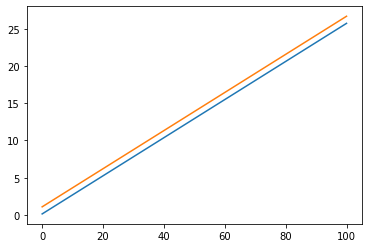

In [185]:
plt.plot(a_grid,c.T)
c_temp = np.copy(c)

In [186]:
indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
a[indexes_asset] = a_grid[0]

In [187]:
indexes_asset

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0,  1,  2,
         3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]))

In [188]:
if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:

    aa = np.zeros((indexes_asset[1].size)) + 1E-5
    rest = -a_grid[0] + wel[indexes_asset[1]]
    bb = c[indexes_asset]
        
    c[indexes_asset] = vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],rest,gamma,v,phi),aa,bb)[1]

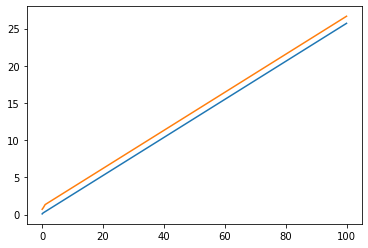

In [189]:
plt.plot(a_grid,c.T)

In [190]:
c - c_temp

array([[-0.05174808, -0.04976536, -0.04756224, -0.04512331, -0.04243316,
        -0.03947658, -0.03623872, -0.03270524, -0.02886251, -0.02469769,
        -0.02019885, -0.01535502, -0.01015619, -0.00459332,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [158]:
vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],rest,gamma,v,phi),aa,bb)[1]

array([0.09732878, 0.10126586, 0.10548311, 0.10999777, 0.1148271 ,
       0.11998828, 0.12549817, 0.13137314, 0.13762896, 0.14428066,
       0.15134243, 0.15882756, 0.16674846, 0.17511663, 0.7191678 ,
       0.72303871, 0.72704968, 0.73120632, 0.73551451, 0.7399804 ,
       0.74461041, 0.74941125, 0.75438994, 0.75955381, 0.76491054,
       0.77046815, 0.77623503, 0.78221995, 0.78843209, 0.79488103,
       0.80157683, 0.80852996, 0.8157514 , 0.82325262, 0.83104561,
       0.83914292, 0.84755764, 0.85630346, 0.86539469, 0.87484627,
       0.88467378, 0.89489351, 0.90552245, 0.91657831, 0.92807956,
       0.94004545, 0.95249603, 0.96545216, 0.97893557, 0.99296882,
       1.00757538, 1.0227796 , 1.03860677, 1.0550831 , 1.07223575,
       1.09009283, 1.10868344, 1.12803763, 1.14818645, 1.16916194,
       1.19099712, 1.21372602, 1.23738362, 1.26200594, 1.28762995,
       1.31429362, 1.34203589])

In [156]:
f_a = consumption(aa,we[indexes_asset[0]],rest,gamma,v,phi)
f_b = consumption(bb,we[indexes_asset[0]],rest,gamma,v,phi)
middle = (aa+bb)/2
f_mid = consumption(middle,we[indexes_asset[0]],rest,gamma,v,phi)
np.nonzero(f_mid*f_a <= 0)[0].size

37

In [115]:
bb.shape

(67,)

In [120]:
consumption(aa,we[indexes_asset[0]],rest,gamma,v,phi)

array([  -947.28909791,   -947.29681901,   -947.30477621,   -947.31297673,
         -947.32142801,   -947.33013772,   -947.33911377,   -947.34836428,
         -947.35789767,   -947.36772257,   -947.37784791,   -947.38828286,
         -947.3990369 ,   -947.41011978, -51720.23282829, -51720.24054939,
       -51720.24850659, -51720.25670712, -51720.2651584 , -51720.27386811,
       -51720.28284415, -51720.29209467, -51720.30162805, -51720.31145296,
       -51720.32157829, -51720.33201324, -51720.34276728, -51720.35385017,
       -51720.36527195, -51720.37704299, -51720.38917398, -51720.40167592,
       -51720.41456014, -51720.42783835, -51720.44152259, -51720.45562528,
       -51720.4701592 , -51720.48513755, -51720.50057392, -51720.51648232,
       -51720.53287716, -51720.54977335, -51720.56718619, -51720.58513149,
       -51720.60362554, -51720.62268511, -51720.64232749, -51720.66257051,
       -51720.68343253, -51720.70493249, -51720.72708988, -51720.74992482,
       -51720.77345802, -

In [121]:
consumption(bb,we[indexes_asset[0]],rest,gamma,v,phi)

array([0.08553319, 0.08058872, 0.07547108, 0.07017452, 0.06469313,
       0.0590208 , 0.05315126, 0.04707806, 0.04079456, 0.0342939 ,
       0.02756906, 0.02061279, 0.01341765, 0.00597596, 0.63200951,
       0.62707434, 0.62198519, 0.61673717, 0.61132524, 0.6057442 ,
       0.59998867, 0.59405311, 0.58793178, 0.58161877, 0.57510797,
       0.56839307, 0.56146757, 0.55432472, 0.54695758, 0.53935899,
       0.53152152, 0.52343752, 0.51509909, 0.50649807, 0.49762602,
       0.48847424, 0.47903372, 0.46929518, 0.45924903, 0.44888534,
       0.43819388, 0.42716407, 0.41578499, 0.40404536, 0.39193352,
       0.37943744, 0.36654467, 0.35324238, 0.33951729, 0.32535572,
       0.31074349, 0.295666  , 0.28010815, 0.26405434, 0.24748846,
       0.2303939 , 0.21275346, 0.19454941, 0.17576343, 0.15637661,
       0.13636941, 0.11572166, 0.09441253, 0.07242053, 0.04972345,
       0.02629838, 0.00212165])

In [92]:
bb

array([0.16398454, 0.16613435, 0.16834989, 0.17063318, 0.17298629,
       0.17541135, 0.17791057, 0.18048622, 0.18314062, 0.18587619,
       0.18869541, 0.19160084, 0.19459511, 0.19768094, 1.211691  ,
       1.2138408 , 1.21605634, 1.21833963, 1.22069274, 1.22311781,
       1.22561703, 1.22819267, 1.23084707, 1.23358264, 1.23640186,
       1.23930729, 1.24230156, 1.2453874 , 1.24856759, 1.25184503,
       1.25522269, 1.25870363, 1.26229101, 1.2659881 , 1.26979823,
       1.27372487, 1.27777159, 1.28194204, 1.28624003, 1.29066944,
       1.29523429, 1.29993874, 1.30478703, 1.30978359, 1.31493293,
       1.32023973, 1.3257088 , 1.33134511, 1.33715377, 1.34314005,
       1.34930939, 1.35566737, 1.36221977, 1.36897254, 1.3759318 ,
       1.38310386, 1.39049523, 1.39811262, 1.40596294, 1.41405331,
       1.42239107, 1.43098379, 1.43983927, 1.44896553, 1.45837086,
       1.46806379, 1.47805312])